In [6]:
import pandas as pd
import random
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import warnings
import os
warnings.filterwarnings("ignore")
from tensorflow.keras import layers, models





In [16]:
path_labels_data = ".\labels_data"
path_arguments_data = ".\arguments_data"

# 1. Corpus

In [17]:
def load_file():
    '''Load the file and return the data and labels for training, testing and validation'''
    
    train_data = pd.read_csv(os.path.join(path_arguments_data, 'arguments-training.tsv'), sep='\t')
    test_data = pd.read_csv(os.path.join(path_arguments_data, 'arguments-test.tsv'), sep='\t')
    valid_data = pd.read_csv(os.path.join(path_arguments_data, 'arguments-validation.tsv'), sep='\t')
    train_labels = pd.read_csv(os.path.join(path_labels_data, 'labels-training.tsv'),sep='\t')
    test_labels = pd.read_csv(os.path.join(path_labels_data, 'labels-test.tsv'),sep='\t')
    valid_labels = pd.read_csv(os.path.join(path_labels_data, 'labels-validation.tsv'),sep='\t')

    return (train_data,train_labels), (test_data,test_labels), (valid_data,valid_labels)
    



(train_data,train_labels), (test_data,test_labels), (valid_data,valid_labels) = load_file()

print("Trainig data shape: ", train_data.shape)
print("Validation data shape: ", valid_data.shape)
print("Test data shape: ", test_data.shape)

print("Level 2 Classes: ", len(train_labels.columns[1:]))

OSError: [Errno 22] Invalid argument: '.\x07rguments_data\\ \\arguments-training.tsv'

In [4]:
train_data.head()

,Argument ID,Conclusion,Stance,Premise
0,A01002,We should ban human cloning,in favor of,we should ban human cloning as it will only ca...
1,A01005,We should ban fast food,in favor of,fast food should be banned because it is reall...
2,A01006,We should end the use of economic sanctions,against,sometimes economic sanctions are the only thin...
3,A01007,We should abolish capital punishment,against,capital punishment is sometimes the only optio...
4,A01008,We should ban factory farming,against,factory farming allows for the production of c...


In [5]:
train_labels.head()

,Argument ID,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,Power: resources,Face,Security: personal,...,Tradition,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity
0,A01002,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,A01005,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,A01006,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,A01007,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
4,A01008,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,1,0,0,0


In [6]:
train_labels.columns


Index(['Argument ID', 'Self-direction: thought', 'Self-direction: action',
       'Stimulation', 'Hedonism', 'Achievement', 'Power: dominance',
       'Power: resources', 'Face', 'Security: personal', 'Security: societal',
       'Tradition', 'Conformity: rules', 'Conformity: interpersonal',
       'Humility', 'Benevolence: caring', 'Benevolence: dependability',
       'Universalism: concern', 'Universalism: nature',
       'Universalism: tolerance', 'Universalism: objectivity'],
      dtype='object')

In [7]:
def merge_df(data, labels):
    return pd.merge(data, labels, on='Argument ID')

In [8]:
l2_train_df = merge_df(train_data, train_labels)
l2_test_df = merge_df(test_data, test_labels)
l2_valid_df = merge_df(valid_data, valid_labels)


In [9]:
l2_train_df.shape

(5393, 24)

In [63]:
for column in l2_train_df.iloc[:,4:].columns:
    print(f"Unique values taken by \"{column}\" label: {np.unique(l2_train_df[column].values)}, number = {l2_train_df[column].nunique()}")
    


Unique values taken by "Self-direction: thought" label: [0 1], number = 2
Unique values taken by "Self-direction: action" label: [0 1], number = 2
Unique values taken by "Stimulation" label: [0 1], number = 2
Unique values taken by "Hedonism" label: [0 1], number = 2
Unique values taken by "Achievement" label: [0 1], number = 2
Unique values taken by "Power: dominance" label: [0 1], number = 2
Unique values taken by "Power: resources" label: [0 1], number = 2
Unique values taken by "Face" label: [0 1], number = 2
Unique values taken by "Security: personal" label: [0 1], number = 2
Unique values taken by "Security: societal" label: [0 1], number = 2
Unique values taken by "Tradition" label: [0 1], number = 2
Unique values taken by "Conformity: rules" label: [0 1], number = 2
Unique values taken by "Conformity: interpersonal" label: [0 1], number = 2
Unique values taken by "Humility" label: [0 1], number = 2
Unique values taken by "Benevolence: caring" label: [0 1], number = 2
Unique val

In [11]:
l2_train_df.head()

,Argument ID,Conclusion,Stance,Premise,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,...,Tradition,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity
0,A01002,We should ban human cloning,in favor of,we should ban human cloning as it will only ca...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,A01005,We should ban fast food,in favor of,fast food should be banned because it is reall...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,A01006,We should end the use of economic sanctions,against,sometimes economic sanctions are the only thin...,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,A01007,We should abolish capital punishment,against,capital punishment is sometimes the only optio...,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
4,A01008,We should ban factory farming,against,factory farming allows for the production of c...,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0


In [12]:
level2_to_level3 = {
    'Openness to change':["Self-direction: thought", "Self-direction: action","Stimulation", "Hedonism"],
    "Self-enhancement":['Hedonism','Achievement', 'Power: dominance', 'Power: resources','Face'],
    "Conservation": ['Face', 'Security: personal', 'Security: societal', 'Tradition', 'Conformity: rules', 'Conformity: interpersonal','Humility'],
    "Self-transcendence":['Humility', 'Benevolence: caring', 'Benevolence: dependability','Universalism: concern', 'Universalism: nature','Universalism: tolerance', 'Universalism: objectivity']
}

    

In [14]:
counts_train = l2_train_df.iloc[:,4:].eq(1).sum()
total_counts_train = counts_train.sum()
print("Count of Level 2 category in Training Dataset: \n\n{}".format(counts_train))
print("\nTotal count of Level 2 categories in Training Dataset: {}".format(total_counts_train))

Count of Level 2 category in Training Dataset: 

Self-direction: thought        988
Self-direction: action        1395
Stimulation                    247
Hedonism                       172
Achievement                   1512
Power: dominance               610
Power: resources               625
Face                           382
Security: personal            2000
Security: societal            1728
Tradition                      568
Conformity: rules             1177
Conformity: interpersonal      207
Humility                       395
Benevolence: caring           1332
Benevolence: dependability     806
Universalism: concern         2081
Universalism: nature           427
Universalism: tolerance        664
Universalism: objectivity     1054
dtype: int64

Total count of Level 2 categories in Training Dataset: 18370


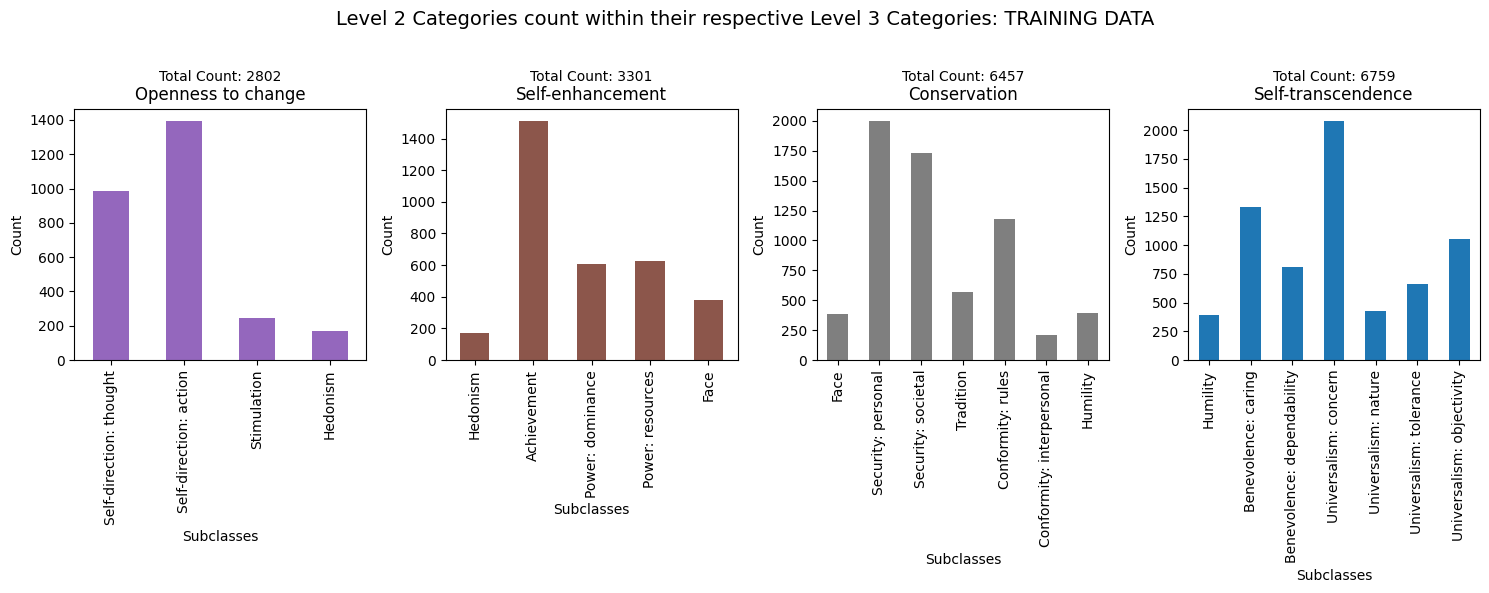

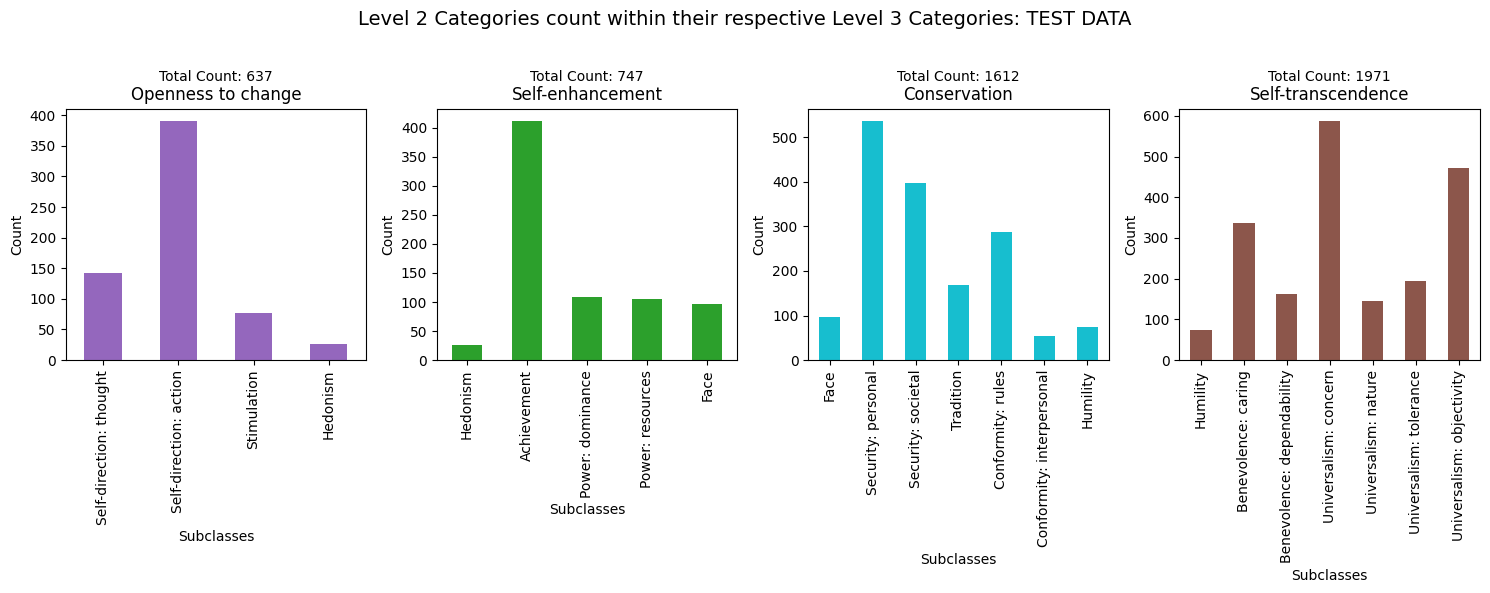

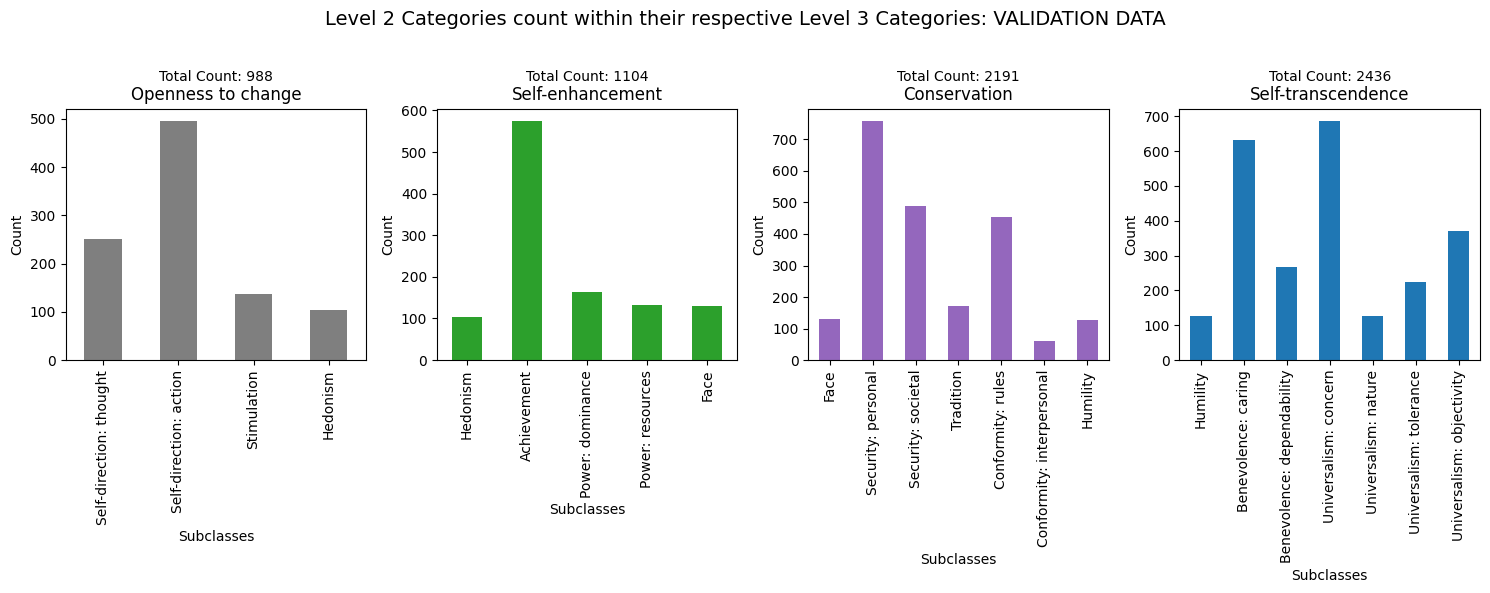

In [24]:
def plot_l2_to_l3_count(df:pd.DataFrame, title):
    '''Plot the histogram of the labels'''
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15,6 ))
    colors = random.sample(list(mcolors.TABLEAU_COLORS.keys()), 4)
    
    for i, (label, subclasses) in enumerate(level2_to_level3.items()):
        ax = axes[i]
        df[subclasses].eq(1).sum().plot(kind='bar', ax=ax, color=colors[i])
        ax.set_title(f'{label}')
        ax.set_xlabel('Subclasses')
        ax.set_ylabel('Count')
        total_count = df[subclasses].eq(1).sum().sum() 
        ax.text(0.5, 1.11, f'Total Count: {total_count}', transform=ax.transAxes, ha='center')  
        
    plt.suptitle(f"Level 2 Categories count within their respective Level 3 Categories: {str.upper(title)} DATA",fontsize=14)
    plt.tight_layout()
    plt.show()

plot_l2_to_l3_count(l2_train_df, "Training")
plot_l2_to_l3_count(l2_test_df, "Test")
plot_l2_to_l3_count(l2_valid_df, "Validation")

    

In [16]:
l2_train_df.describe()


,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,Power: resources,Face,Security: personal,Security: societal,Tradition,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity
count,5393.000000,5393.000000,5393.000000,5393.000000,5393.000000,5393.000000,5393.000000,5393.000000,5393.000000,5393.000000,5393.000000,5393.000000,5393.000000,5393.000000,5393.000000,5393.000000,5393.000000,5393.000000,5393.000000,5393.000000
mean,0.183200,0.258669,0.045800,0.031893,0.280363,0.113110,0.115891,0.070833,0.370851,0.320415,0.105322,0.218246,0.038383,0.073243,0.246987,0.149453,0.385871,0.079177,0.123123,0.195439
std,0.386867,0.437944,0.209071,0.175732,0.449218,0.316756,0.320124,0.256569,0.483077,0.466679,0.306996,0.413094,0.192137,0.260559,0.431299,0.356567,0.486845,0.270039,0.328608,0.396575
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [17]:
def get_level3_labels_df(df,labels_df):
    label3_df = labels_df[['Argument ID']].copy()
    
    for label3, labels2 in level2_to_level3.items():
        start_label = labels2[0]
        end_label = labels2[-1] 
        label3_df[label3] = (labels_df.loc[:,start_label:end_label].sum(axis=1) > 0).astype("float32")
        
    l3_df = pd.merge(df, label3_df, on='Argument ID')

    return l3_df

train_df = get_level3_labels_df(train_data,train_labels)
test_df = get_level3_labels_df(test_data,test_labels)
valid_df = get_level3_labels_df(valid_data,valid_labels)
train_df.head()


,Argument ID,Conclusion,Stance,Premise,Openness to change,Self-enhancement,Conservation,Self-transcendence
0,A01002,We should ban human cloning,in favor of,we should ban human cloning as it will only ca...,0.0,0.0,1.0,0.0
1,A01005,We should ban fast food,in favor of,fast food should be banned because it is reall...,0.0,0.0,1.0,0.0
2,A01006,We should end the use of economic sanctions,against,sometimes economic sanctions are the only thin...,0.0,1.0,1.0,0.0
3,A01007,We should abolish capital punishment,against,capital punishment is sometimes the only optio...,0.0,0.0,1.0,1.0
4,A01008,We should ban factory farming,against,factory farming allows for the production of c...,0.0,0.0,1.0,1.0


In [18]:
train_df.shape

(5393, 8)

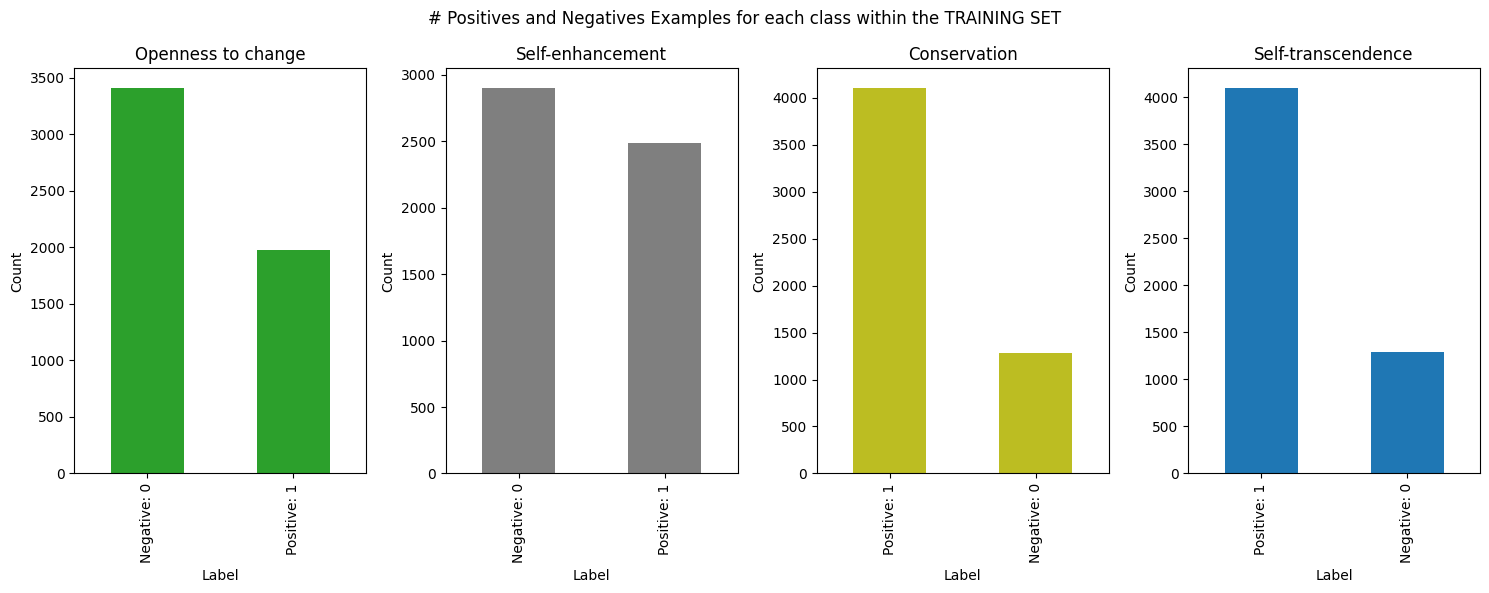

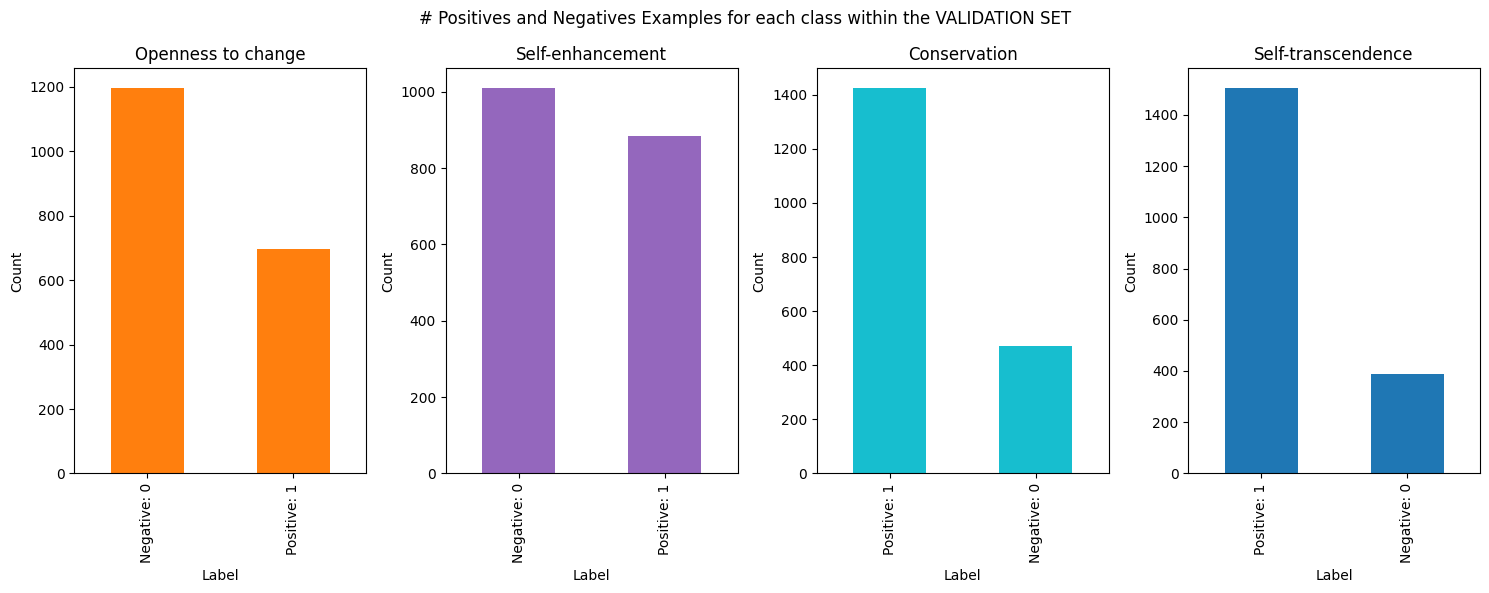

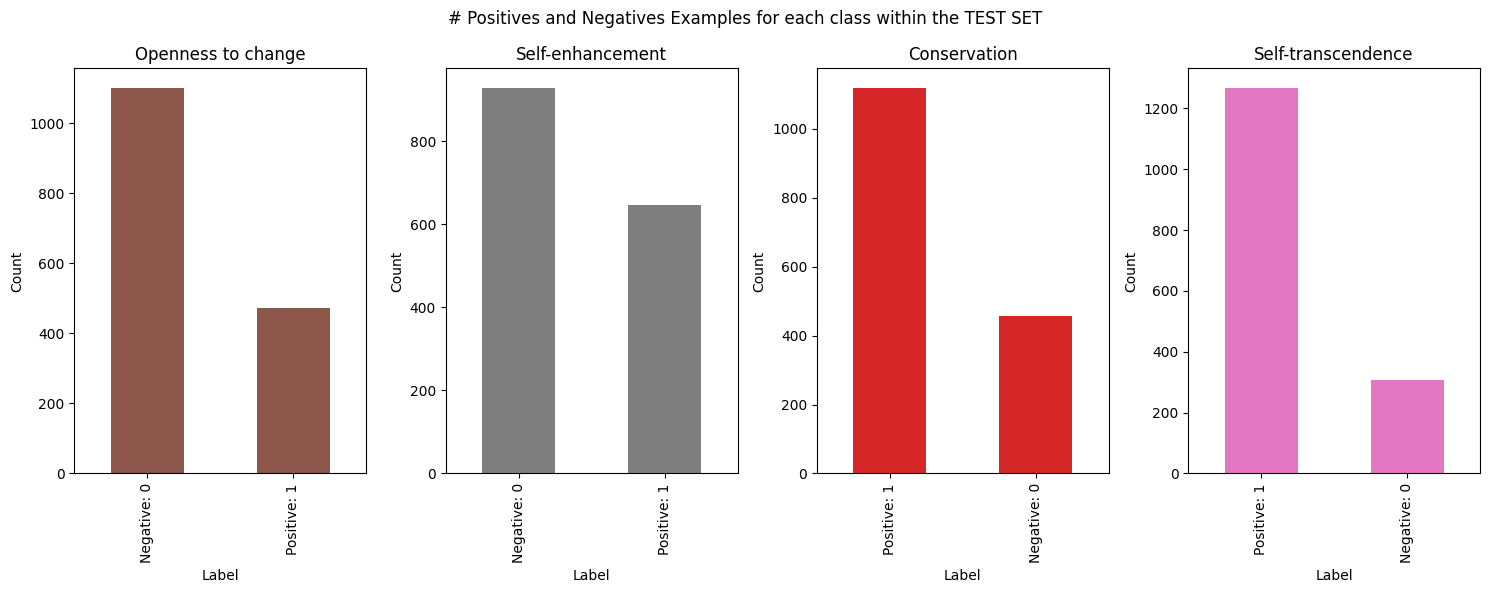

In [177]:
def plot_label_count(df: pd.DataFrame, title:str):
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 6))
    colors = random.sample(list(mcolors.TABLEAU_COLORS.keys()), 4)
    labels = list(level2_to_level3.keys())


    for i,label in enumerate(labels):
        ax = axes[i]
        count_labels = df[label].replace({0: 'Negative: 0', 1: 'Positive: 1'}).value_counts()
        count_labels.plot(kind='bar', ax=ax, color=colors[i], label=label)
        ax.set_title(f'{label}')
        ax.set_xlabel('Label')
        ax.set_ylabel('Count')
        
    plt.suptitle(f'# Positives and Negatives Examples for each class within the {str.upper(title)} SET', fontsize=12)
    plt.tight_layout()
    plt.show()

plot_label_count(train_df,"training")
plot_label_count(valid_df,"Validation")
plot_label_count(test_df,"Test")

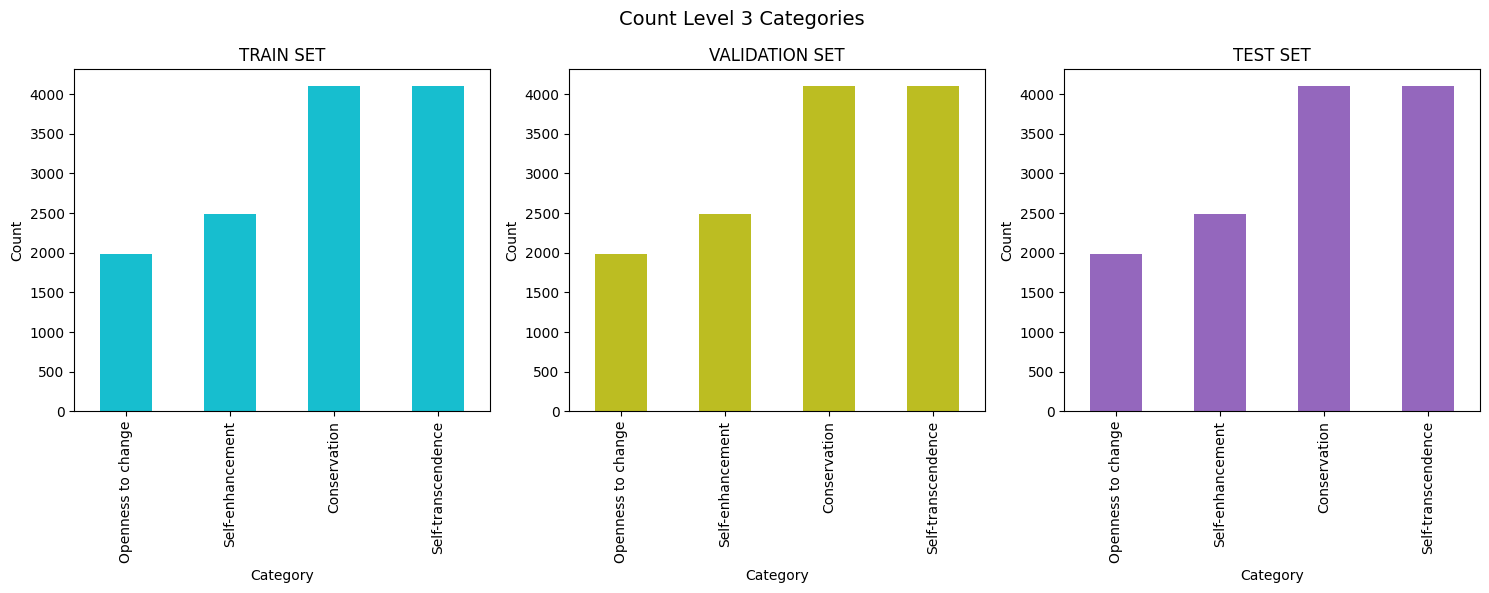

In [58]:

def plot_samples_per_class(df_train, df_valid, df_test):

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))
    axes = axes.flatten()
    colors = random.sample(list(mcolors.TABLEAU_COLORS.keys()), 4)
    labels = list(level2_to_level3.keys())

    for i in range(3):
        ax = axes[i]
        train_counts = df_train[labels].eq(1).sum()
        valid_counts = df_valid[labels].eq(1).sum()
        test_counts = df_test[labels].eq(1).sum()
        
        train_counts.plot(kind='bar', ax=ax, color=colors[i])
        valid_counts.plot(kind='bar', ax=ax, color=colors[i])
        test_counts.plot(kind='bar', ax=ax, color=colors[i])
        ax.set_title(f'{["TRAIN SET", "VALIDATION SET", "TEST SET"][i]}')
        ax.set_xlabel('Category')
        ax.set_ylabel('Count')
        ax.set_xticklabels(labels)

        
    plt.suptitle('Count Level 3 Categories ', fontsize=14)
    plt.tight_layout()
    plt.show()


plot_samples_per_class(train_df,valid_df,test_df)

In [55]:
train_df.describe()

,Openness to change,Self-enhancement,Conservation,Self-transcendence
count,5393.000000,5393.000000,5393.000000,5393.000000
mean,0.366957,0.461524,0.761543,0.761172
std,0.482019,0.498564,0.426180,0.426407
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,1.000000
50%,0.000000,0.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000


### Maybe these analyses don't make much sense.

In [82]:
correlation_matrix = train_df[['Openness to change', 'Self-enhancement', 'Conservation', 'Self-transcendence']].corr()
print(correlation_matrix)


                    Openness to change  Self-enhancement  Conservation  \
Openness to change            1.000000          0.115484     -0.189673   
Self-enhancement              0.115484          1.000000     -0.043188   
Conservation                 -0.189673         -0.043188      1.000000   
Self-transcendence           -0.134770         -0.064169      0.018234   

                    Self-transcendence  
Openness to change           -0.134770  
Self-enhancement             -0.064169  
Conservation                  0.018234  
Self-transcendence            1.000000  


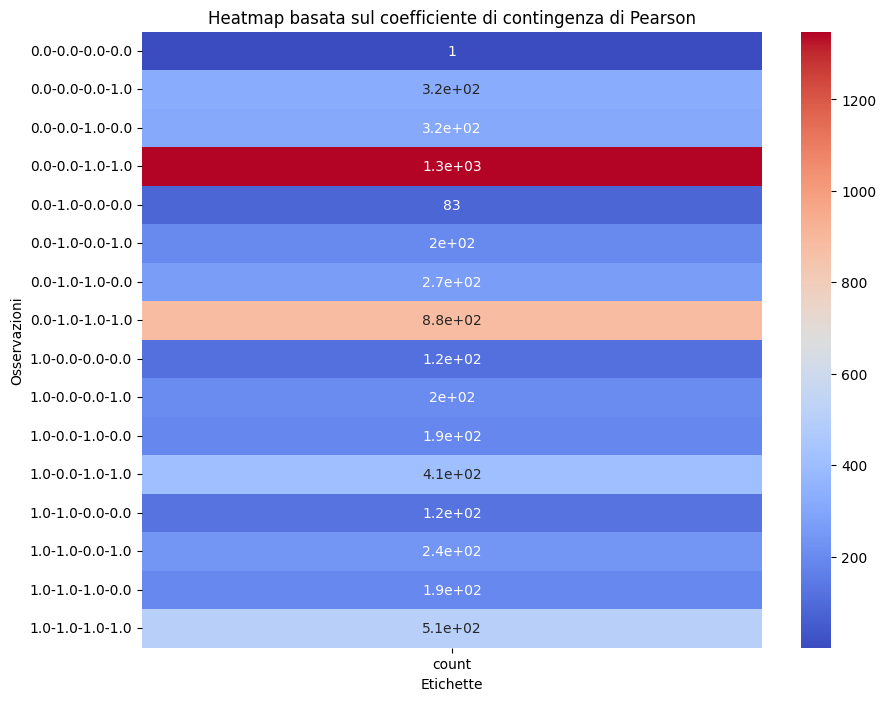

In [78]:

contingency_table = pd.crosstab(index=[train_df['Openness to change'],train_df['Self-enhancement'],train_df['Conservation'], train_df['Self-transcendence']], columns='count')

plt.figure(figsize=(10, 8))
sns.heatmap(contingency_table, annot=True, cmap="coolwarm")
plt.title('Heatmap basata sul coefficiente di contingenza di Pearson')
plt.xlabel('Etichette')
plt.ylabel('Osservazioni')
plt.show()

# 2 Models Definition

### BASELINE MODELS

In [179]:
#Random Unifor Classifier

num_samples = len(train_data)
num_classes = 4
true_labels = train_df.iloc[:,4:].values


random_predictions = np.random.uniform(size=(num_samples, num_classes))

random_predictions[random_predictions >= 0.5] = 1
random_predictions[random_predictions < 0.5] = 0


model = models.Sequential([
    layers.Input(shape=(num_classes,)),  
    layers.Dense(4,activation="sigmoid")  
])

model.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=['accuracy'])



# Evaluate the model
loss, accuracy = model.evaluate(random_predictions,true_labels)
print(f'Loss: {loss}, Accuracy: {accuracy}')


169/169 [==============================] - 0s 2ms/step - loss: 0.7009 - accuracy: 0.2010
Loss: 0.700911819934845, Accuracy: 0.20100130140781403


In [181]:
#Majoirty Classifier

true_labels = train_df.iloc[:,4:].values
num_samples = len(train_df)
num_labels = 4


majority_class = train_df.iloc[:,4:].value_counts().idxmax()  
majority_class = np.array([majority_class] * len(train_df))



accuracy = np.mean(true_labels == majority_class)
print("Accuracy Training set:", accuracy)


Accuracy: 0.6735583163359911


In [182]:
true_labels = test_df.iloc[:,4:].values
num_samples = len(test_df)
num_labels = 4


majority_class = test_df.iloc[:,4:].value_counts().idxmax()  
majority_class = np.array([majority_class] * len(test_df))



accuracy = np.mean(true_labels == majority_class)
print("Accuracy Test Set:", accuracy)

Accuracy Test Set: 0.7008248730964467


In [183]:
true_labels = valid_df.iloc[:,4:].values
num_samples = len(valid_df)
num_labels = 4


majority_class = valid_df.iloc[:,4:].value_counts().idxmax()  
majority_class = np.array([majority_class] * len(valid_df))



accuracy = np.mean(true_labels == majority_class)
print("Accuracy Validation Set:", accuracy)

Accuracy Validation Set: 0.6778744725738397
